In [1]:
%matplotlib inline

import math
import datetime

import numpy as np

from pandas import DataFrame
from pandas import concat

import tensorflow as tf
from tensorflow import keras

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

debug = True

In [2]:
import pip 

cuda = False

l = next(str(i) for i in pip.get_installed_distributions() if 'tensorflow' in str(i))
if l.startswith('tensorflow-gpu'):
    cuda = True

In [3]:
#MATLAB colors
colors = [[0, 0.4470, 0.7410],
          [0.8500, 0.3250, 0.0980],
          [0.9290, 0.6940, 0.1250],
          [0.4940, 0.1840, 0.5560],
          [0.4660, 0.6740, 0.1880],
          [0.3010, 0.7450, 0.9330],
          [0.6350, 0.0780, 0.1840]];

colormap = plt.get_cmap('rainbow')

def getColor(num, brightness=1):
    col = colors[num]
    return [col[0]*brightness, col[1]*brightness, col[2]*brightness]

In [4]:
N = 5 #Number of experiments
 
def encode(msg):
    encoded = [0]*8
    for x in msg:
        if x.startswith('m1'):
            encoded[0] = 1.0
        elif x.startswith('m2'):
            encoded[1] = 1.0
        elif x.startswith('m3'):
            encoded[2] = 1.0
        elif x == 'a':
            encoded[3] = 1.0
        elif x == 'b':
            encoded[4] = 1.0
        elif x == 'c':
            encoded[5] = 1.0  
        elif x == 'd':
            encoded[6] = 1.0   
        elif x == 'e':
            encoded[7] = 1.0
    return encoded

def decode(encoded):
    message = ''
    if (encoded[0] > encoded[1] and encoded[0] > encoded[2]):
        message = 'm1'
    elif (encoded[1] > encoded[0] and encoded[1] > encoded[2]):
        message = 'm2'
    elif (encoded[2] > encoded[0] and encoded[2] > encoded[1]):
        message = 'm3'
    else:
        message = 'm?'
        
    params = ''
    if (encoded[3] >= 0.5):
        params = params + ' a '
    if (encoded[4] >= 0.5):
        params = params + ' b '
    if (encoded[5] >= 0.5):
        params = params + ' c '
    if (encoded[6] >= 0.5):
        params = params + ' d '
    if (encoded[7] >= 0.5):
        params = params + ' e '        
        
    return message + '(' + params + ')'
        

def logToData(filename):
    file = open(filename)
    while True:
        line = file.readline()      
        if not line:
            break        
        if line.startswith('!'):
            raw_bytes = list(line[1:].strip().split(',')[:-1])
            raw_bytes_float = []
            for b in raw_bytes:
                raw_bytes_float.append(int(b)/255)
            while True:
                line = file.readline()      
                if not line:
                    break        
                elif line.startswith('@'):
                    encoded = encode(line.split('@')[2].split(','))
                    yield raw_bytes_float, encoded
                    break;    

In [5]:
def loadAllData(base, N):
    logs = []
    maxbytelen = 0
    for i in range(1,N+1):
        log = list(logToData(base+str(i)+'.log'))
        logs.append(log)
        for msg in log:
            length = len(msg[0])
            maxbytelen = max(maxbytelen, length)
    X = []
    Y = []
    for log in logs:
        x = np.zeros((len(log),maxbytelen))
        y = np.zeros((len(log),8))
        for i, msg in enumerate(log):
            x[i,0:len(msg[0])] = msg[0]
            y[i,:] = msg[1]
        X.append(x)
        Y.append(y)
    return X, Y

In [6]:
base_dir = '../../../target/thingml-bytes-logs/nodejs/'

base_X, base_Y = loadAllData(base_dir+'base/nodejs', N)
static_X, static_Y = loadAllData(base_dir+'static/nodejs', N)
runtime_X, runtime_Y = loadAllData(base_dir+'dynamic/nodejs', N)

In [7]:
def split(data, train_ratio = 0.67):
    train = []
    test = []
    for log in data:
        length = log.shape[0]
        train_size = int(length * train_ratio)
        train.append(log[0:train_size,:])
        test.append(log[train_size:,:])
    return train, test

base_X_train, base_X_test = split(base_X)
base_Y_train, base_Y_test = split(base_Y)
static_X_train, static_X_test = split(static_X)
static_Y_train, static_Y_test = split(static_Y)
runtime_X_train, runtime_X_test = split(runtime_X)
runtime_Y_train, runtime_Y_test = split(runtime_Y)

In [8]:
def keras_model(x, y):    
    model = keras.Sequential()
    #model.add(keras.layers.Dropout(0.2, input_shape=(x,)))
    model.add(keras.layers.Dense(45*y, activation='relu', input_dim=(x)))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(15*y, activation='relu'))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(y, activation='sigmoid'))
    #sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'binary_accuracy'])    
    return model

def train_and_save(model, train_X, train_Y, test_X, test_Y, mode, xp, save=False):     
    earlystop_loss = keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    earlystop_val_loss = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=10, verbose=1, mode='min')
    earlystop_acc = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0.0001, patience=10, verbose=1, mode='max')
    earlystop_val_acc = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=10, verbose=1, mode='max')
    callbacks_list = [earlystop_loss, earlystop_val_loss, earlystop_acc, earlystop_val_acc]  
    
    model.fit(train_X, train_Y, batch_size=1, epochs=100, validation_split=0.1, verbose=1, callbacks=callbacks_list)

    if save:
        keras.models.save_model(model, base_dir + mode + str(xp) + '.h5', overwrite=True, include_optimizer=True)
#     if debug:
#         result = model.evaluate(test_X, test_Y)
#         print(result)
    return model

In [9]:
def predict(model, test_X, test_Y):

    predictions = model.predict(test_X)
    predictions = np.round(predictions)
    
    if debug:
        plt.figure(1, figsize=(15,6))
        plt.plot(np.abs(test_Y.flatten() - predictions.flatten()))
        plt.show()
    
    errors = 0
    for i in range(0, len(test_Y)):
        if np.sum(test_Y[i][3:8]) == 0: #does not contain parameter
            continue
        errs = np.sum(np.abs(test_Y[i] - predictions[i]))
        if errs > 0:
            errors = errors + 1
            if debug:
                print('Predicting ', decode(predictions[i]), '. Truth is ', decode(test_Y[i]))
        
    error_ratio = round((errors/len(test_Y)*100),2)

    return error_ratio

In [10]:
def xp(train_X, train_Y, test_X, test_Y, mode):
    print('xp ', mode)
    results = []
    for i in range(0, N):        
        model = keras_model(train_X[i].shape[1], train_Y[i].shape[1])
        train_start = datetime.datetime.now()
        model = train_and_save(model, train_X[i], train_Y[i], test_X[i], test_Y[i], mode, i, save=True)
        model.summary()
        train_stop = predict_start = datetime.datetime.now()
        error_ratio = predict(model, test_X[i], test_Y[i])
        predict_stop = datetime.datetime.now()
        train_duration = train_stop - train_start
        predict_duration = predict_stop - predict_start
        print(error_ratio, '% error')
        print('training duration = ', train_duration)
        print('prediction duration = ', predict_duration)
        results.append((error_ratio, train_duration, predict_duration))
    return results

xp  base
Train on 165 samples, validate on 19 samples
Epoch 1/100
165/165 [==============================] - 3s 16ms/step - loss: 0.5923 - acc: 0.6939 - binary_accuracy: 0.6939 - val_loss: 0.5458 - val_acc: 0.7039 - val_binary_accuracy: 0.7039
Epoch 2/100
165/165 [==============================] - 1s 4ms/step - loss: 0.5161 - acc: 0.7250 - binary_accuracy: 0.7250 - val_loss: 0.4320 - val_acc: 0.7829 - val_binary_accuracy: 0.7829
Epoch 3/100
165/165 [==============================] - 1s 4ms/step - loss: 0.3479 - acc: 0.8417 - binary_accuracy: 0.8417 - val_loss: 0.2601 - val_acc: 0.8421 - val_binary_accuracy: 0.8421
Epoch 4/100
165/165 [==============================] - 1s 4ms/step - loss: 0.2560 - acc: 0.8379 - binary_accuracy: 0.8379 - val_loss: 0.2257 - val_acc: 0.8684 - val_binary_accuracy: 0.8684
Epoch 5/100
165/165 [==============================] - 1s 4ms/step - loss: 0.2414 - acc: 0.8402 - binary_accuracy: 0.8402 - val_loss: 0.2106 - val_acc: 0.9539 - val_binary_accuracy: 0.9539


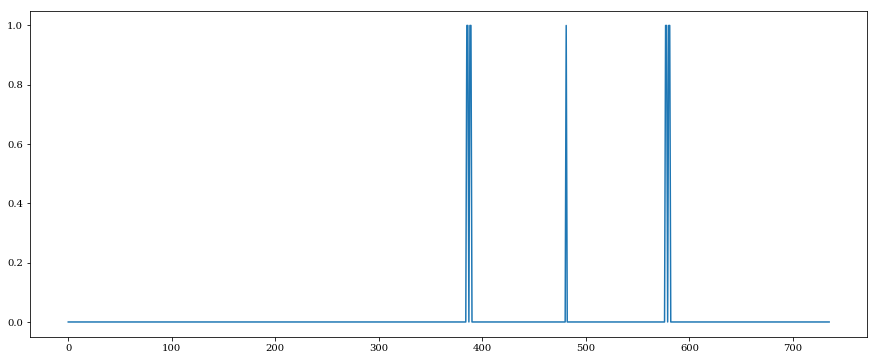

Predicting  m3( a ) . Truth is  m2( a  b  c )
Predicting  m?( a  b  c ) . Truth is  m2( a  b  c )
Predicting  m3( a ) . Truth is  m2( a  b  c )
3.26 % error
training duration =  0:00:15.311398
prediction duration =  0:00:00.181986
Train on 169 samples, validate on 19 samples
Epoch 1/100
169/169 [==============================] - 1s 7ms/step - loss: 0.5886 - acc: 0.6901 - binary_accuracy: 0.6901 - val_loss: 0.5307 - val_acc: 0.7171 - val_binary_accuracy: 0.7171
Epoch 2/100
169/169 [==============================] - 1s 4ms/step - loss: 0.4966 - acc: 0.7537 - binary_accuracy: 0.7537 - val_loss: 0.4106 - val_acc: 0.8355 - val_binary_accuracy: 0.8355
Epoch 3/100
169/169 [==============================] - 1s 4ms/step - loss: 0.3328 - acc: 0.8343 - binary_accuracy: 0.8343 - val_loss: 0.2737 - val_acc: 0.8289 - val_binary_accuracy: 0.8289
Epoch 4/100
169/169 [==============================] - 1s 4ms/step - loss: 0.2558 - acc: 0.8543 - binary_accuracy: 0.8543 - val_loss: 0.2379 - val_acc: 0.914

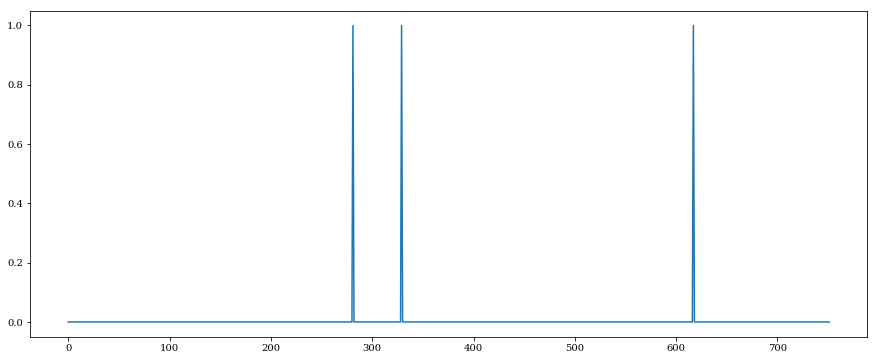

Predicting  m?( a  b  c ) . Truth is  m2( a  b  c )
Predicting  m?( a  b  c ) . Truth is  m2( a  b  c )
Predicting  m?( a  b  c ) . Truth is  m2( a  b  c )
3.19 % error
training duration =  0:00:18.377146
prediction duration =  0:00:00.187001
Train on 163 samples, validate on 19 samples
Epoch 1/100
163/163 [==============================] - 1s 7ms/step - loss: 0.5993 - acc: 0.6902 - binary_accuracy: 0.6902 - val_loss: 0.5417 - val_acc: 0.7171 - val_binary_accuracy: 0.7171
Epoch 2/100
163/163 [==============================] - 1s 4ms/step - loss: 0.5129 - acc: 0.7186 - binary_accuracy: 0.7186 - val_loss: 0.4337 - val_acc: 0.8355 - val_binary_accuracy: 0.8355
Epoch 3/100
163/163 [==============================] - 1s 4ms/step - loss: 0.3607 - acc: 0.8252 - binary_accuracy: 0.8252 - val_loss: 0.2829 - val_acc: 0.8816 - val_binary_accuracy: 0.8816
Epoch 4/100
163/163 [==============================] - 1s 4ms/step - loss: 0.2682 - acc: 0.8351 - binary_accuracy: 0.8351 - val_loss: 0.2427 - va

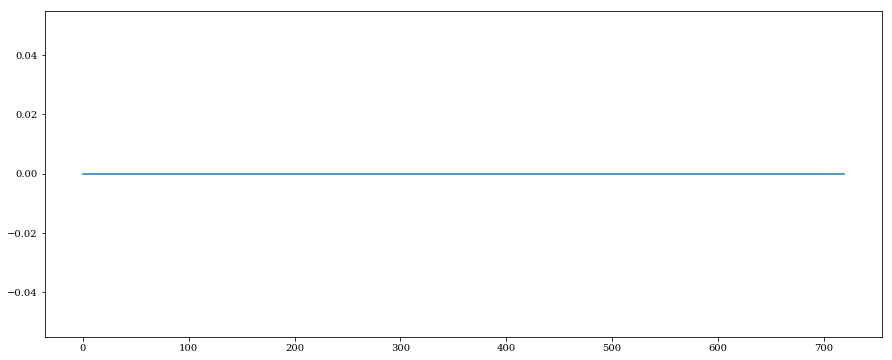

0.0 % error
training duration =  0:00:15.476668
prediction duration =  0:00:00.194789
Train on 180 samples, validate on 21 samples
Epoch 1/100
180/180 [==============================] - 1s 7ms/step - loss: 0.5832 - acc: 0.6944 - binary_accuracy: 0.6944 - val_loss: 0.5399 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
180/180 [==============================] - 1s 4ms/step - loss: 0.5077 - acc: 0.7340 - binary_accuracy: 0.7340 - val_loss: 0.4110 - val_acc: 0.8333 - val_binary_accuracy: 0.8333
Epoch 3/100
180/180 [==============================] - 1s 4ms/step - loss: 0.3358 - acc: 0.8236 - binary_accuracy: 0.8236 - val_loss: 0.2655 - val_acc: 0.8155 - val_binary_accuracy: 0.8155
Epoch 4/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2594 - acc: 0.8451 - binary_accuracy: 0.8451 - val_loss: 0.2310 - val_acc: 0.8333 - val_binary_accuracy: 0.8333
Epoch 5/100
180/180 [==============================] - 1s 4ms/step - loss: 0.2362 - acc: 0.8556 - binary_accuracy

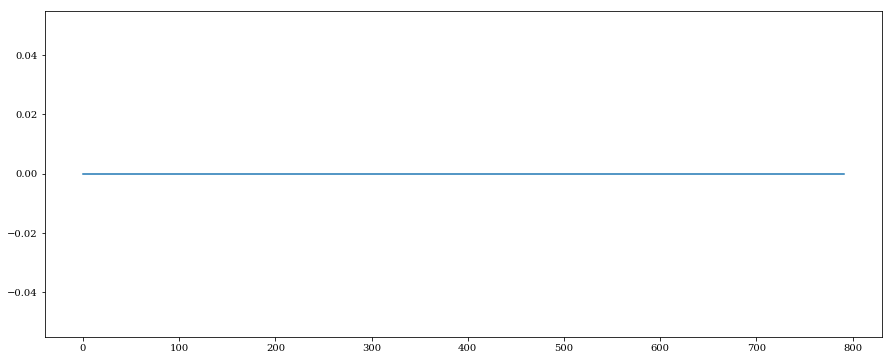

0.0 % error
training duration =  0:00:16.064913
prediction duration =  0:00:00.246572
Train on 162 samples, validate on 18 samples
Epoch 1/100
162/162 [==============================] - 1s 9ms/step - loss: 0.5924 - acc: 0.6937 - binary_accuracy: 0.6937 - val_loss: 0.5326 - val_acc: 0.7083 - val_binary_accuracy: 0.7083
Epoch 2/100
162/162 [==============================] - 1s 5ms/step - loss: 0.4767 - acc: 0.7423 - binary_accuracy: 0.7423 - val_loss: 0.3637 - val_acc: 0.8333 - val_binary_accuracy: 0.8333
Epoch 3/100
162/162 [==============================] - 1s 5ms/step - loss: 0.3010 - acc: 0.8364 - binary_accuracy: 0.8364 - val_loss: 0.2716 - val_acc: 0.8750 - val_binary_accuracy: 0.8750
Epoch 4/100
162/162 [==============================] - 1s 4ms/step - loss: 0.2531 - acc: 0.8457 - binary_accuracy: 0.8457 - val_loss: 0.2191 - val_acc: 0.8125 - val_binary_accuracy: 0.8125
Epoch 5/100
162/162 [==============================] - 1s 5ms/step - loss: 0.2230 - acc: 0.8750 - binary_accuracy

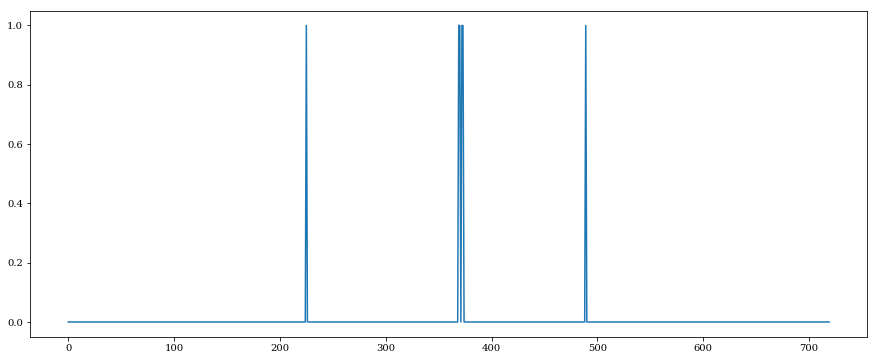

Predicting  m?( a  b  c ) . Truth is  m2( a  b  c )
Predicting  m3( a ) . Truth is  m2( a  b  c )
Predicting  m?( a  b  c ) . Truth is  m2( a  b  c )
3.33 % error
training duration =  0:00:13.339619
prediction duration =  0:00:00.265709
xp  static
Train on 342 samples, validate on 39 samples
Epoch 1/100
342/342 [==============================] - 2s 6ms/step - loss: 0.4509 - acc: 0.7807 - binary_accuracy: 0.7807 - val_loss: 0.3457 - val_acc: 0.8173 - val_binary_accuracy: 0.8173
Epoch 2/100
342/342 [==============================] - 1s 4ms/step - loss: 0.3288 - acc: 0.8056 - binary_accuracy: 0.8056 - val_loss: 0.2982 - val_acc: 0.8462 - val_binary_accuracy: 0.8462
Epoch 3/100
342/342 [==============================] - 1s 4ms/step - loss: 0.2720 - acc: 0.8567 - binary_accuracy: 0.8567 - val_loss: 0.2281 - val_acc: 0.8942 - val_binary_accuracy: 0.8942
Epoch 4/100
342/342 [==============================] - 1s 4ms/step - loss: 0.1894 - acc: 0.9185 - binary_accuracy: 0.9185 - val_loss: 0.1352

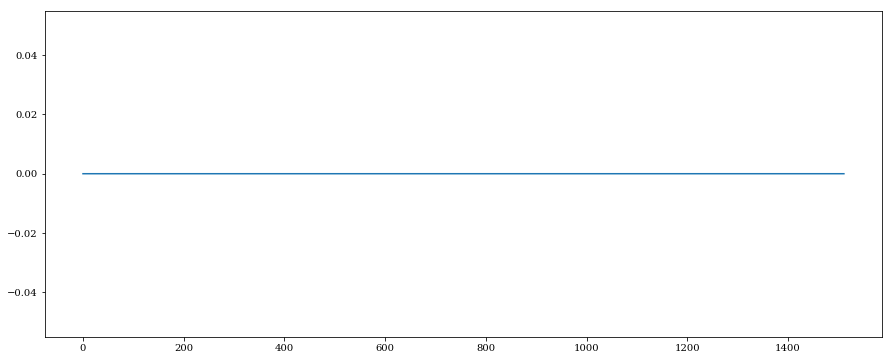

0.0 % error
training duration =  0:00:34.293850
prediction duration =  0:00:00.245672
Train on 313 samples, validate on 35 samples
Epoch 1/100
313/313 [==============================] - 2s 6ms/step - loss: 0.5491 - acc: 0.7496 - binary_accuracy: 0.7496 - val_loss: 0.4133 - val_acc: 0.8250 - val_binary_accuracy: 0.8250
Epoch 2/100
313/313 [==============================] - 1s 4ms/step - loss: 0.3330 - acc: 0.8403 - binary_accuracy: 0.8403 - val_loss: 0.2717 - val_acc: 0.8679 - val_binary_accuracy: 0.8679
Epoch 3/100
313/313 [==============================] - 1s 4ms/step - loss: 0.2487 - acc: 0.8770 - binary_accuracy: 0.8770 - val_loss: 0.2147 - val_acc: 0.8893 - val_binary_accuracy: 0.8893
Epoch 4/100
313/313 [==============================] - 1s 4ms/step - loss: 0.2034 - acc: 0.8946 - binary_accuracy: 0.8946 - val_loss: 0.1696 - val_acc: 0.9500 - val_binary_accuracy: 0.9500
Epoch 5/100
313/313 [==============================] - 1s 4ms/step - loss: 0.1736 - acc: 0.9185 - binary_accuracy

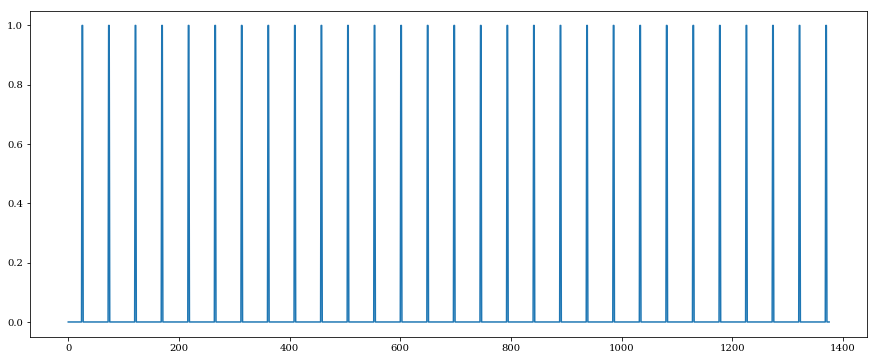

0.0 % error
training duration =  0:00:26.938647
prediction duration =  0:00:00.290701
Train on 331 samples, validate on 37 samples
Epoch 1/100
331/331 [==============================] - 2s 6ms/step - loss: 0.3462 - acc: 0.8659 - binary_accuracy: 0.8659 - val_loss: 0.1420 - val_acc: 0.9392 - val_binary_accuracy: 0.9392
Epoch 2/100
331/331 [==============================] - 1s 4ms/step - loss: 0.1377 - acc: 0.9309 - binary_accuracy: 0.9309 - val_loss: 0.1369 - val_acc: 0.9189 - val_binary_accuracy: 0.9189
Epoch 3/100
331/331 [==============================] - 1s 4ms/step - loss: 0.1337 - acc: 0.9264 - binary_accuracy: 0.9264 - val_loss: 0.1172 - val_acc: 0.9392 - val_binary_accuracy: 0.9392
Epoch 4/100
331/331 [==============================] - 1s 4ms/step - loss: 0.1257 - acc: 0.9347 - binary_accuracy: 0.9347 - val_loss: 0.1224 - val_acc: 0.9392 - val_binary_accuracy: 0.9392
Epoch 5/100
331/331 [==============================] - 1s 4ms/step - loss: 0.1255 - acc: 0.9320 - binary_accuracy

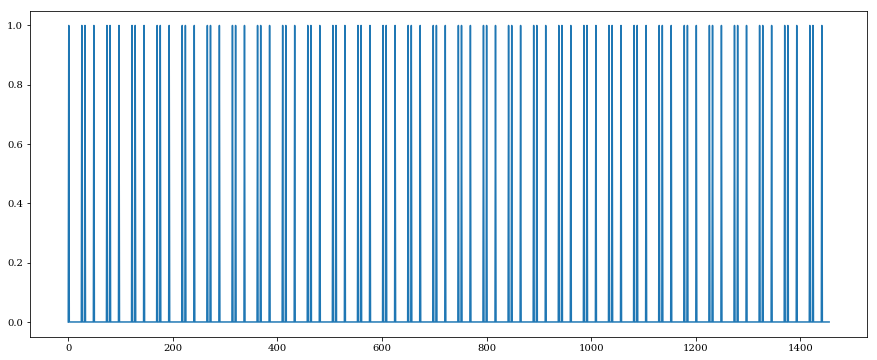

0.0 % error
training duration =  0:00:16.423082
prediction duration =  0:00:00.346799
Train on 327 samples, validate on 37 samples
Epoch 1/100
327/327 [==============================] - 2s 7ms/step - loss: 0.3055 - acc: 0.8941 - binary_accuracy: 0.8941 - val_loss: 0.1320 - val_acc: 0.9358 - val_binary_accuracy: 0.9358
Epoch 2/100
327/327 [==============================] - 1s 4ms/step - loss: 0.1320 - acc: 0.9323 - binary_accuracy: 0.9323 - val_loss: 0.1240 - val_acc: 0.9358 - val_binary_accuracy: 0.9358
Epoch 3/100
327/327 [==============================] - 1s 4ms/step - loss: 0.1290 - acc: 0.9297 - binary_accuracy: 0.9297 - val_loss: 0.1243 - val_acc: 0.9358 - val_binary_accuracy: 0.9358
Epoch 4/100
327/327 [==============================] - 1s 4ms/step - loss: 0.1235 - acc: 0.9350 - binary_accuracy: 0.9350 - val_loss: 0.1337 - val_acc: 0.9122 - val_binary_accuracy: 0.9122
Epoch 5/100
327/327 [==============================] - 1s 4ms/step - loss: 0.1231 - acc: 0.9323 - binary_accuracy

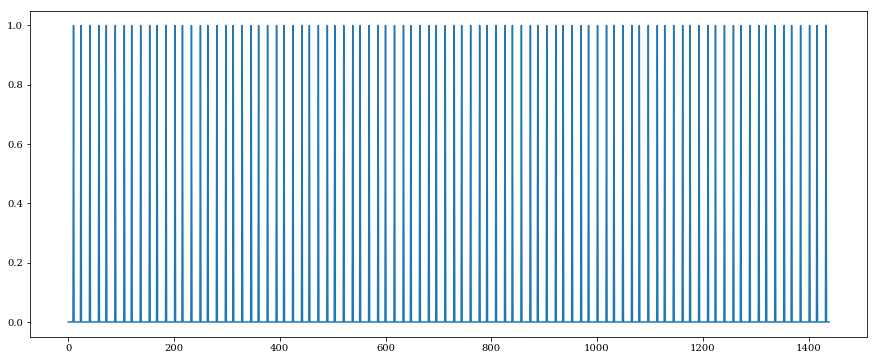

0.0 % error
training duration =  0:00:16.656174
prediction duration =  0:00:00.337550
Train on 298 samples, validate on 34 samples
Epoch 1/100
298/298 [==============================] - 2s 7ms/step - loss: 0.4838 - acc: 0.7735 - binary_accuracy: 0.7735 - val_loss: 0.2975 - val_acc: 0.9154 - val_binary_accuracy: 0.9154
Epoch 2/100
298/298 [==============================] - 1s 4ms/step - loss: 0.2200 - acc: 0.9090 - binary_accuracy: 0.9090 - val_loss: 0.1687 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 3/100
298/298 [==============================] - 1s 4ms/step - loss: 0.1595 - acc: 0.9279 - binary_accuracy: 0.9279 - val_loss: 0.1491 - val_acc: 0.9191 - val_binary_accuracy: 0.9191
Epoch 4/100
298/298 [==============================] - 1s 4ms/step - loss: 0.1406 - acc: 0.9346 - binary_accuracy: 0.9346 - val_loss: 0.1307 - val_acc: 0.9375 - val_binary_accuracy: 0.9375
Epoch 5/100
298/298 [==============================] - 1s 4ms/step - loss: 0.1393 - acc: 0.9316 - binary_accuracy

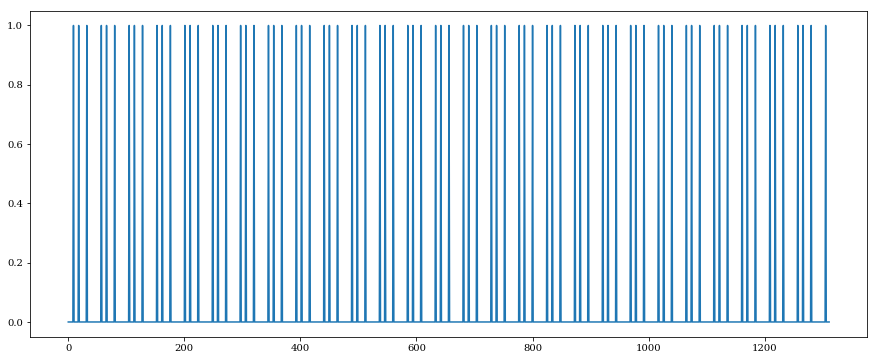

0.0 % error
training duration =  0:00:16.421369
prediction duration =  0:00:00.345277
xp  runtime
Train on 356 samples, validate on 40 samples
Epoch 1/100
356/356 [==============================] - 2s 7ms/step - loss: 0.4611 - acc: 0.7820 - binary_accuracy: 0.7820 - val_loss: 0.3387 - val_acc: 0.8500 - val_binary_accuracy: 0.8500
Epoch 2/100
356/356 [==============================] - 1s 4ms/step - loss: 0.3312 - acc: 0.8241 - binary_accuracy: 0.8241 - val_loss: 0.2999 - val_acc: 0.8500 - val_binary_accuracy: 0.8500
Epoch 3/100
356/356 [==============================] - 1s 4ms/step - loss: 0.2904 - acc: 0.8501 - binary_accuracy: 0.8501 - val_loss: 0.2538 - val_acc: 0.8531 - val_binary_accuracy: 0.8531
Epoch 4/100
356/356 [==============================] - 1s 4ms/step - loss: 0.2379 - acc: 0.8725 - binary_accuracy: 0.8725 - val_loss: 0.2205 - val_acc: 0.9187 - val_binary_accuracy: 0.9187
Epoch 5/100
356/356 [==============================] - 1s 4ms/step - loss: 0.2141 - acc: 0.8971 - bin

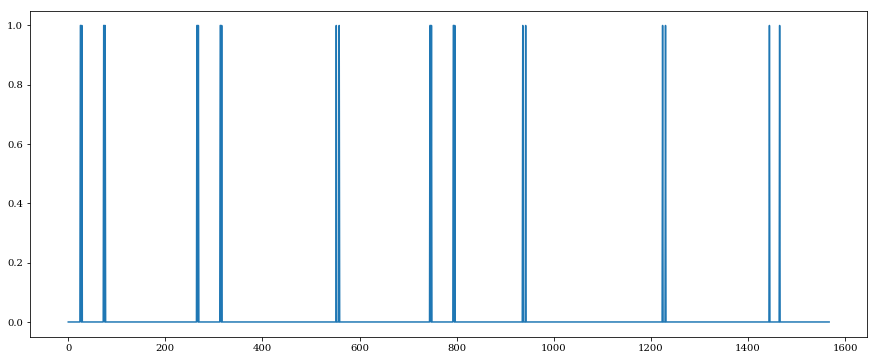

Predicting  m3() . Truth is  m2( b )
Predicting  m3() . Truth is  m2( b )
Predicting  m3() . Truth is  m2( b )
Predicting  m3() . Truth is  m2( b )
Predicting  m?( c  d ) . Truth is  m2( c )
Predicting  m3() . Truth is  m2( b )
Predicting  m3() . Truth is  m2( b )
Predicting  m?( c  d ) . Truth is  m2( c )
Predicting  m?( c  d ) . Truth is  m2( c )
Predicting  m1( c  d ) . Truth is  m1( b  c  d )
Predicting  m?( c ) . Truth is  m2( c )
5.61 % error
training duration =  0:00:32.233377
prediction duration =  0:00:00.366685
Train on 352 samples, validate on 40 samples
Epoch 1/100
352/352 [==============================] - 3s 7ms/step - loss: 0.4456 - acc: 0.7979 - binary_accuracy: 0.7979 - val_loss: 0.3109 - val_acc: 0.8406 - val_binary_accuracy: 0.8406
Epoch 2/100
352/352 [==============================] - 1s 4ms/step - loss: 0.3103 - acc: 0.8381 - binary_accuracy: 0.8381 - val_loss: 0.2758 - val_acc: 0.8562 - val_binary_accuracy: 0.8562
Epoch 3/100
352/352 [=============================

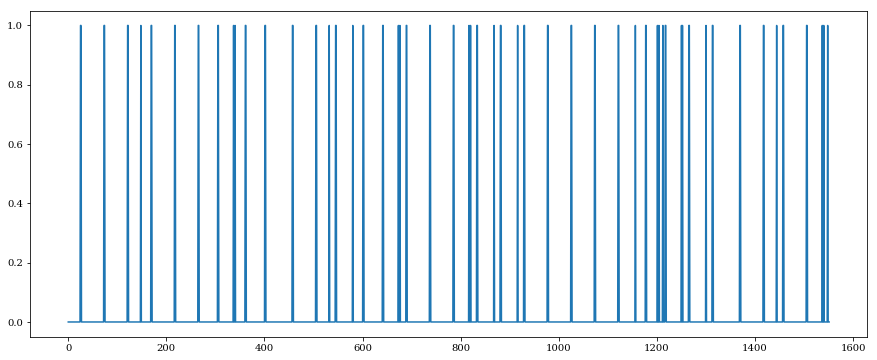

Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m?() . Truth is  m2( b )
Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m?() . Truth is  m2( b )
Predicting  m?() . Truth is  m2( b )
Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m?() . Truth is  m2( b )
Predicting  m2( a  b  c ) . Truth is  m2( a  c )
Predicting  m?( a  c ) . Truth is  m2( a  b  c )
Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m2( a  c ) . Truth is  m2( a  b  c )
Predicting  m?() . Truth is  m2( b )
Predicting  m2( a  b  c ) . Truth is  m2( a  c )
8.25 % error
training duration =  0:00:23.949185
prediction duration =  0:00:00.381669
Train on 306 samples, validate on 35 samples
Epoch 1/100
306/306 [==============================] - 2s 8ms/step - loss: 0.6037 - acc: 0.6810 - binary_accuracy: 0.6810 - val_loss: 0.5397 - v

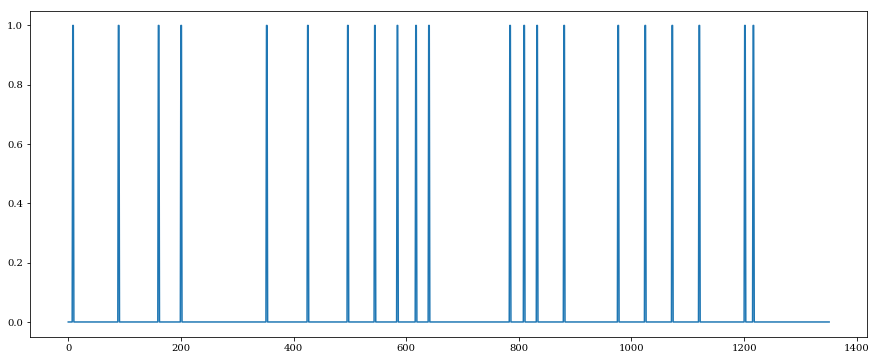

0.0 % error
training duration =  0:00:35.646862
prediction duration =  0:00:00.409143
Train on 316 samples, validate on 36 samples
Epoch 1/100
316/316 [==============================] - 2s 8ms/step - loss: 0.4902 - acc: 0.7571 - binary_accuracy: 0.7571 - val_loss: 0.3970 - val_acc: 0.8021 - val_binary_accuracy: 0.8021
Epoch 2/100
316/316 [==============================] - 1s 4ms/step - loss: 0.3573 - acc: 0.8157 - binary_accuracy: 0.8157 - val_loss: 0.3352 - val_acc: 0.8611 - val_binary_accuracy: 0.8611
Epoch 3/100
316/316 [==============================] - 1s 4ms/step - loss: 0.3311 - acc: 0.8350 - binary_accuracy: 0.8350 - val_loss: 0.3201 - val_acc: 0.8299 - val_binary_accuracy: 0.8299
Epoch 4/100
316/316 [==============================] - 1s 4ms/step - loss: 0.2993 - acc: 0.8489 - binary_accuracy: 0.8489 - val_loss: 0.2787 - val_acc: 0.8924 - val_binary_accuracy: 0.8924
Epoch 5/100
316/316 [==============================] - 1s 4ms/step - loss: 0.2714 - acc: 0.8687 - binary_accuracy

316/316 [==============================] - 1s 4ms/step - loss: 0.0348 - acc: 0.9873 - binary_accuracy: 0.9873 - val_loss: 0.0225 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 44/100
316/316 [==============================] - 1s 4ms/step - loss: 0.0311 - acc: 0.9889 - binary_accuracy: 0.9889 - val_loss: 0.0605 - val_acc: 0.9583 - val_binary_accuracy: 0.9583
Epoch 45/100
316/316 [==============================] - 1s 4ms/step - loss: 0.0323 - acc: 0.9885 - binary_accuracy: 0.9885 - val_loss: 0.0191 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 46/100
316/316 [==============================] - 1s 4ms/step - loss: 0.0481 - acc: 0.9826 - binary_accuracy: 0.9826 - val_loss: 0.0225 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 47/100
316/316 [==============================] - 1s 4ms/step - loss: 0.0320 - acc: 0.9909 - binary_accuracy: 0.9909 - val_loss: 0.0190 - val_acc: 0.9931 - val_binary_accuracy: 0.9931
Epoch 48/100
316/316 [==============================] - 1s 4ms/

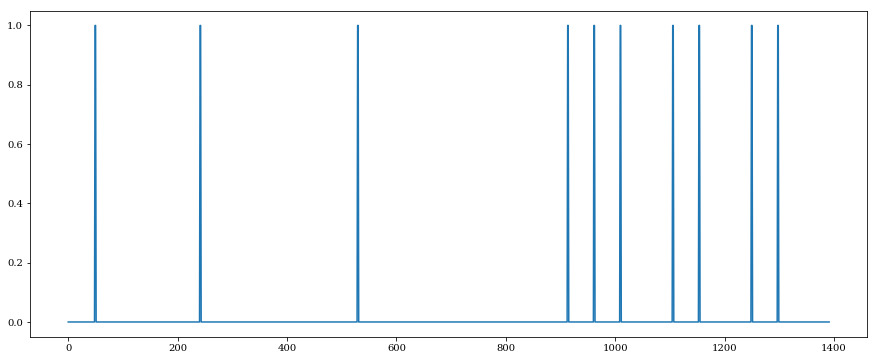

0.0 % error
training duration =  0:01:05.964087
prediction duration =  0:00:00.404673
Train on 284 samples, validate on 32 samples
Epoch 1/100
284/284 [==============================] - 2s 9ms/step - loss: 0.4726 - acc: 0.7742 - binary_accuracy: 0.7742 - val_loss: 0.3105 - val_acc: 0.8281 - val_binary_accuracy: 0.8281
Epoch 2/100
284/284 [==============================] - 1s 4ms/step - loss: 0.2854 - acc: 0.8499 - binary_accuracy: 0.8499 - val_loss: 0.2659 - val_acc: 0.8477 - val_binary_accuracy: 0.8477
Epoch 3/100
284/284 [==============================] - 1s 4ms/step - loss: 0.2660 - acc: 0.8482 - binary_accuracy: 0.8482 - val_loss: 0.2568 - val_acc: 0.8594 - val_binary_accuracy: 0.8594
Epoch 4/100
284/284 [==============================] - 1s 4ms/step - loss: 0.2449 - acc: 0.8693 - binary_accuracy: 0.8693 - val_loss: 0.2350 - val_acc: 0.8789 - val_binary_accuracy: 0.8789
Epoch 5/100
284/284 [==============================] - 1s 4ms/step - loss: 0.2358 - acc: 0.8790 - binary_accuracy

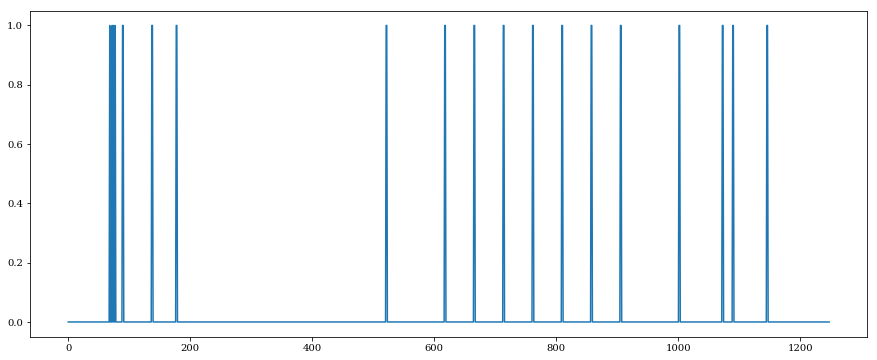

Predicting  m1( a  d  e ) . Truth is  m1( a  b  d  e )
Predicting  m3() . Truth is  m1( c )
Predicting  m2( b  c ) . Truth is  m1( b  c )
1.92 % error
training duration =  0:00:43.958009
prediction duration =  0:00:00.452699


In [11]:
base_results = xp(base_X_train, base_Y_train, base_X_test, base_Y_test, 'base')
static_results = xp(static_X_train, static_Y_train, static_X_test, static_Y_test, 'static')
runtime_results = xp(runtime_X_train, runtime_Y_train, runtime_X_test, runtime_Y_test, 'runtime')

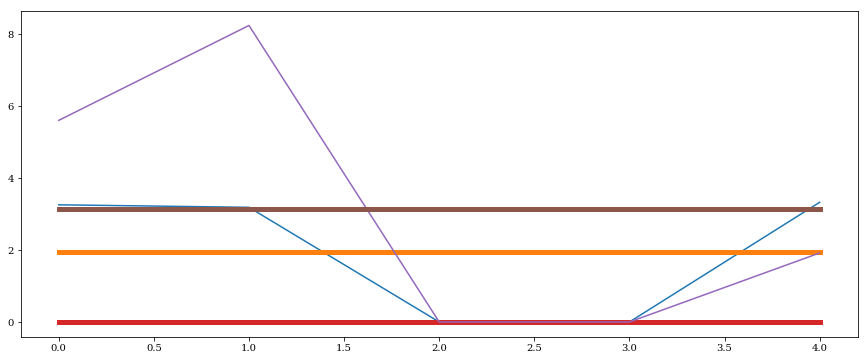

In [12]:
def get_errors(results, errors):
    for e,_,_ in results:
        errors.append(e)        

        
base_errors = []
get_errors(base_results, base_errors)

static_errors = []
get_errors(static_results, static_errors)

runtime_errors = []
get_errors(runtime_results, runtime_errors)


plt.figure(4, figsize=(15,6))
plt.plot(base_errors)
mean = np.mean(base_errors)
plt.plot([0, len(base_errors)-1], [mean, mean], linewidth=5)
plt.plot(static_errors)
mean = np.mean(static_errors)
plt.plot([0, len(static_errors)-1], [mean, mean], linewidth=5)
plt.plot(runtime_errors)
mean = np.mean(runtime_errors)
plt.plot([0, len(runtime_errors)-1], [mean, mean], linewidth=5)
plt.show()